In [15]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import seaborn
import statsmodels.api as sm
from scipy.stats import zscore
from statsmodels import regression
from statsmodels.tsa.stattools import coint

In [16]:
def seleciona_dados(s1,s2):
    _tick1 = s1[6:]
    _tick2 = s2[6:]

    dados = data[[s1,s2]].copy()
    dados[('Ch'+_tick1)],dados[('Ch'+_tick2)] = dados[s1].pct_change(),dados[s2].pct_change()
    dados = dados[1:]
    dados.columns = [_tick1,_tick2,s1,s2]
    return dados

def calcula_zscore_spread(dados, period):
    c = 0
    list_zs = [None]*period
    for i in range(period,len(dados)):
        S1 = dados[s1][c:i]
        S2 = dados[s2][c:i]
        S1 = sm.add_constant(S1)
        results = sm.OLS(S2,S1).fit()
        S1 = S1[s1]
        b = results.params[s1]
        spread = S2 - (b*S1)
        zs = zscore(spread)
        list_zs.append(zs[-1])
        c+=1
    return list_zs

In [51]:
l_zs = []
entrada = 0
def operador_high(dados, gatilho, encerra, carteira, t1,t2):
    posicao = 0 #1 - posicionado | 0 - neutro
    compra = 0
    venda = 0
    
    fin_long  = 0 #financeiro ponta long
    fin_short = 0 #financeiro ponta short 
    l_resultado = []
    l_cart = []
    
    for index in range(len(dados)):
        zs = dados['zs_spread'][dados.index == index+1].values[0]
        p_s1 = float(dados[t1][dados.index == index+1].values)
        p_s2 = float(dados[t2][dados.index == index+1].values)

        #abre operacao
        if zs >= gatilho and posicao == 0:
            q = (p_s1/p_s2) 
            v = carteira/2/p_s1 #volume de acordo com carteira
            l_zs.append(zs)
            fin_long  += p_s1*v   # 
            fin_short -= p_s2*v*q #  
            
            posicao = 1 #esta posicionado
        #encerra
        elif (zs > -encerra and zs < encerra) and posicao == 1:
#             print(f' C {compra:.2f} | V {venda:.2f} | ')
            fin_long   -= p_s1*v   #creditando venda da posicao
            fin_short  += p_s2*v*q #debita encerramento posicao
            
            posicao = 0 #esta neutro
            
            resultado = fin_long + fin_short
            print(resultado)
            fin_long,fin_short = 0,0
#             print(f'res: {resultado:.2f} | l:{fin_long:.2f} | s:{fin_short:.2f}')
            l_resultado.append(resultado)
            carteira+=resultado
            l_cart.append(carteira)
#             print(f'cart: {carteira:.2f}\n')
            
    return l_resultado, l_cart

In [52]:
data = pd.read_excel('/home/daniel/Desktop/Projetos/mql_python/Relatório 1/dados_relatorio.xlsx')

In [53]:
def seleciona_dados(s1,s2):
    _tick1 = s1[6:]
    _tick2 = s2[6:]

    dados = data[[s1,s2]].copy()
    dados[('Ch'+_tick1)],dados[('Ch'+_tick2)] = dados[s1].pct_change(),dados[s2].pct_change()
    dados = dados[1:]
    dados.columns = [_tick1,_tick2,s1,s2]
    return dados

In [54]:
s1,s2 = 'close ITUB4','close ITSA4'
dados = seleciona_dados(s1=s1,s2=s2)

In [55]:
dados.head()

,ITUB4,ITSA4,close ITUB4,close ITSA4
1,10.60,3.82,0.000944,0.000000
2,10.52,3.81,-0.007547,-0.002618
3,10.60,3.83,0.007605,0.005249
4,10.66,3.85,0.005660,0.005222
5,10.80,3.91,0.013133,0.015584


In [56]:
s1,s2 = 'close ITUB4','close ITSA4'
dados = seleciona_dados(s1=s1,s2=s2)

In [57]:
dados['zs_spread'] = calcula_zscore_spread(dados,period=90)

In [58]:
dados.tail()

,ITUB4,ITSA4,close ITUB4,close ITSA4,zs_spread
1970,35.38,13.37,-0.004502,-0.008895,-0.711491
1971,35.71,13.46,0.009327,0.006731,-0.992644
1972,36.26,13.70,0.015402,0.017831,-0.260281
1973,36.16,13.64,-0.002758,-0.004380,0.756416
1974,35.96,13.60,-0.005531,-0.002933,-0.505642


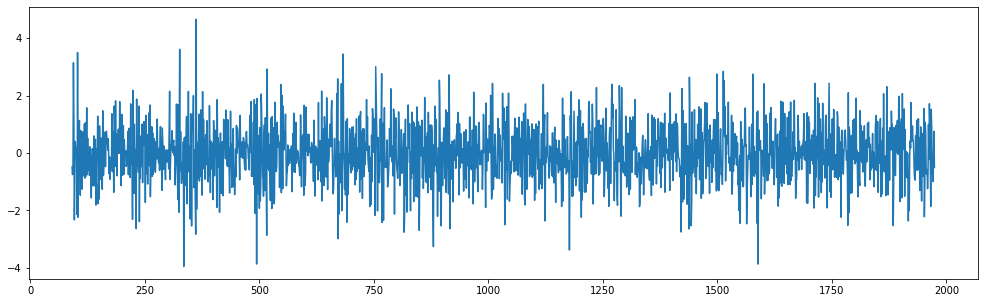

In [59]:
plt.figure(figsize=[17,5])
plt.plot(dados.zs_spread)


In [60]:
t1,t2 = 'ITUB4','ITSA4'
gats = [1.1] #lista de valores para ativar o gatilho da operacao 
encr = [.08] #valores para encerrar a operacao
capital = 10000 #valor inicial aportado 
testes = []

for i in gats:
    for j in encr:
        result = operador_high(dados,gatilho=i,encerra=j,carteira=capital,t1=t2,t2=t1)
        trades = result[0]
        testes.append(trades)

9.68958167737037
-16.275888646224303
86.65585443363398
-40.363923309515485
-37.86526905661958
47.55531264376532
-23.87124351971852
84.2930787035948
22.428558860121484
58.65754105015458
-43.18633031227
148.32772759786076
-109.00927653640792
19.129493893260587
137.30886560248746
9.260048418156657
-0.903379941667481
13.626830427746427
59.537926693408735
-3.10242125937566
-14.231856996811985
81.79591570618413
48.93282895495486
-111.09939263227352
-42.567005956578214
-80.86943695069021
-13.88467889882395
21.267759331581146
75.61483997200139
-11.361370864206492
74.35472053885587
168.18101138038946
-19.355505651829844
-223.76419181016263
79.60286488651491
-38.84995554150282
10.498180212229272
178.05288810609636
218.6937925752527
-162.01446231094997
-106.88055520054968
76.82105868202416
-75.82337767759145
-40.52596691915369
34.20501591862558
115.92522411721166
-1.1940615448793324
-51.59070571571192
33.604189728974234
-193.37246903088726
-34.71466492368654
86.47254757251267
26.14164104153133
78

Soma: 269.3577 | Gati=1.1,Encr=0.08
                0
count   73.000000
mean     3.689832
std     81.595591
min   -223.764192
25%    -42.567006
50%     -1.194062
75%     58.657541
max    218.693793




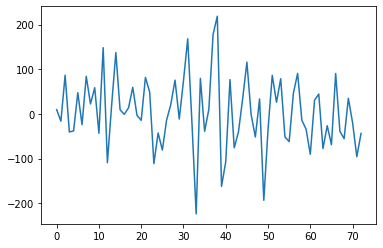

In [61]:
cont = 0
for i in gats:
    for j in encr:
        des = pd.DataFrame(testes[cont])
        print(f'Soma: {float(des.sum()):.4f} | Gati={i},Encr={j}')
        print(des.describe())
        print('\n')
        plt.plot(des)
        cont+=1

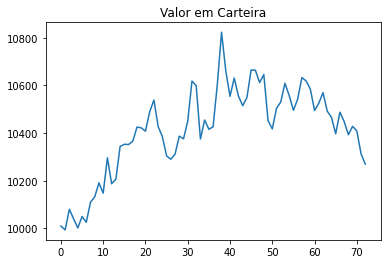

In [42]:
plt.title('Valor em Carteira')
plt.plot(result[1])
plt.show()

In [43]:
pd.DataFrame(l_zs)

,0
0,3.141610
1,1.573471
2,1.284350
3,1.367611
4,1.791391
...,...
69,1.460079
70,1.130465
71,1.681226
72,1.756838


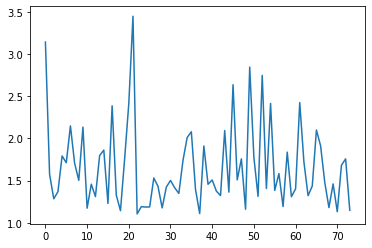

In [30]:
plt.plot(l_zs)